In [1]:
%load_ext autoreload
%autoreload 2

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from utils.network import VarNet, rakiSpirit
import torch
from script.train_knee3d import *
from utils.cg_spirit_gpu import *
from utils.dataset import *
from scipy.linalg import null_space
import fastmri.data.transforms as T
from functools import partial
from utils.evaluation import esp

import robust_loss_pytorch.general

%matplotlib inline

In [2]:
R = 14

fname = 'data/div_knee3d/Test/18.h5'

Kspace size:(320, 8, 256, 320)
Calib size:(100, 8, 20, 20)
Max value: 7834.080078125


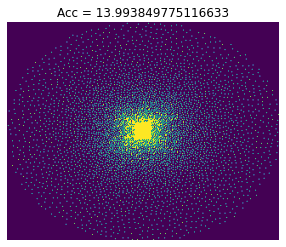

In [3]:
# Preparing data

with h5py.File(fname,'r') as hr:
    kspace = hr['kspace'][:]

nkx, nc, nkz, nky = kspace.shape

#kspace = sp.fft(kspace, axes=[0]) # Make 3D kspace

#norm_value = 100 / np.max(np.abs(kspace)) 
#kspace = kspace * norm_value # Normalizing kspace

kspace = kspace * 1e-3

im_comb = sp.rss(sp.ifft(kspace, axes=[2,3]), axes=1) # For fully sampled recon img

mask = sigpy.mri.poisson([nkz, nky], R,
        calib=[20,20],
        dtype=np.float32)

plt.imshow(mask) # This is what mask looks like
plt.axis('off')
plt.title('Acc = {}'.format(1/mask.mean()))

print('Kspace size:{}'.format(kspace.shape))

calib = sp.resize(kspace,[100,nc,20,20])

print('Calib size:{}'.format(calib.shape))
print('Max value: {}'.format(np.max(np.abs(calib))))


# Calibrate G (2D CNN)

In [4]:
calib_tensor = torch.from_numpy(calib)
calib_tensor = calib_tensor.cuda()
#kspace_tensor = torch.from_numpy(np.moveaxis(kspace,0,-1)[None,]).cuda()
kspace_tensor = torch.from_numpy(kspace[100:101]).cuda()

print(calib_tensor.shape)
print(kspace_tensor.shape)

torch.Size([100, 8, 20, 20])
torch.Size([1, 8, 256, 320])


In [5]:
net = rakiSpirit(8,8)
net = net.cuda()

In [6]:
calib_real = torch.view_as_real(calib_tensor)

In [7]:
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cuda:0')

params = list(net.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr=0.004)

In [8]:
num_epochs = 1001

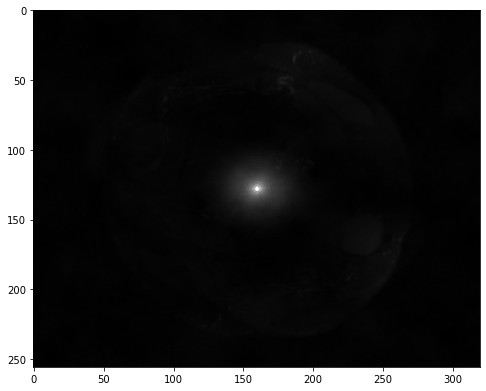

Epoch [0/1001] Loss=181.164047, ACS Loss=180.958435, KSP Loss=9.064597, alpha=0.998002, scale=1.002530


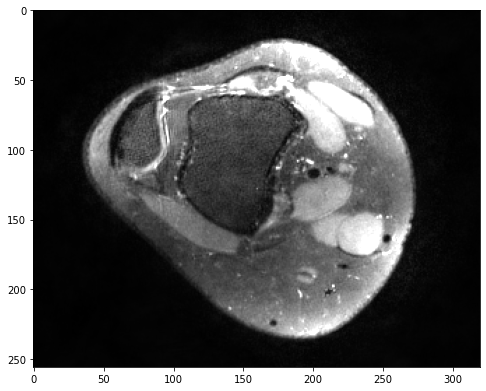

Epoch [100/1001] Loss=16.327202, ACS Loss=20.696947, KSP Loss=5.303524, alpha=0.923011, scale=1.127927


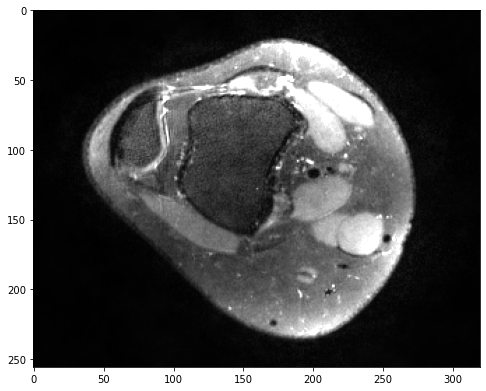

Epoch [200/1001] Loss=12.384974, ACS Loss=17.013987, KSP Loss=5.256706, alpha=0.892959, scale=1.204542


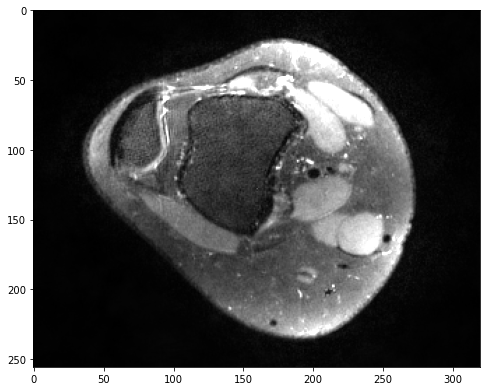

Epoch [300/1001] Loss=10.526942, ACS Loss=15.485844, KSP Loss=5.231938, alpha=0.866746, scale=1.277958


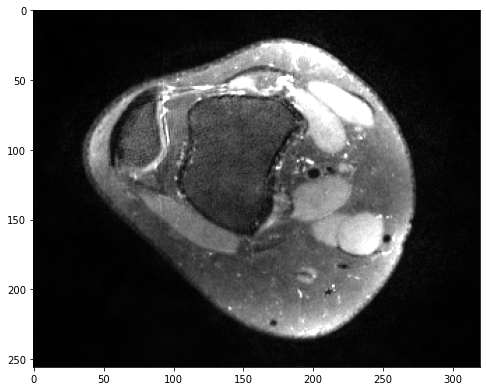

Epoch [400/1001] Loss=9.143353, ACS Loss=14.136528, KSP Loss=5.218320, alpha=0.843775, scale=1.347597


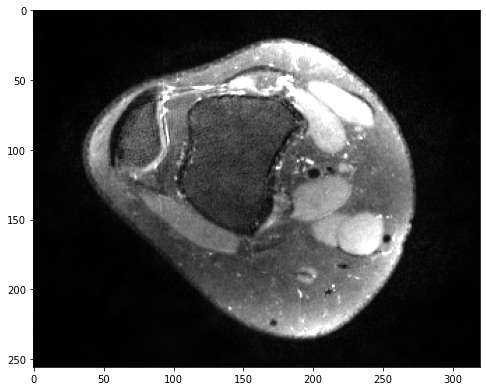

Epoch [500/1001] Loss=7.921430, ACS Loss=12.605853, KSP Loss=5.205099, alpha=0.823047, scale=1.414590


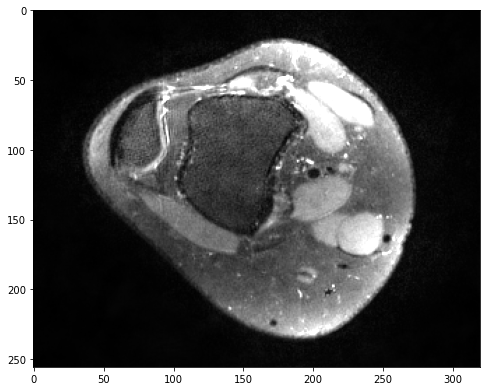

Epoch [600/1001] Loss=7.233301, ACS Loss=11.864786, KSP Loss=5.204483, alpha=0.804269, scale=1.478914


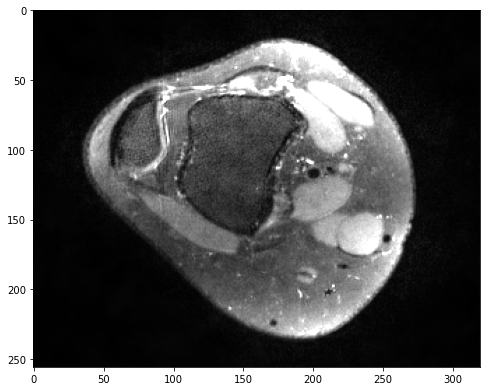

Epoch [700/1001] Loss=6.974576, ACS Loss=11.927373, KSP Loss=5.201030, alpha=0.787013, scale=1.541139


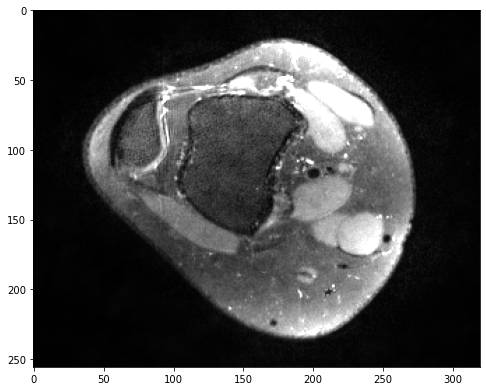

Epoch [800/1001] Loss=6.761445, ACS Loss=12.004852, KSP Loss=5.192844, alpha=0.771053, scale=1.601425


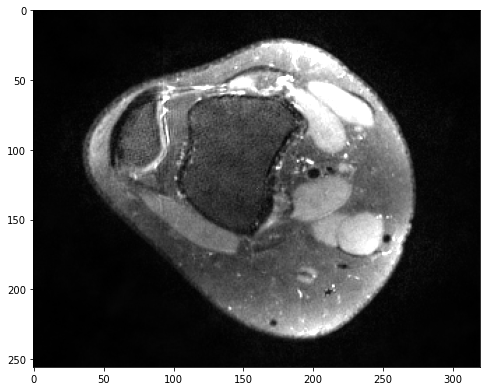

Epoch [900/1001] Loss=6.265560, ACS Loss=11.253779, KSP Loss=5.178625, alpha=0.756081, scale=1.660400


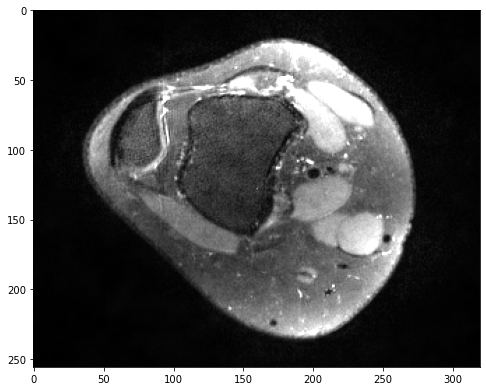

Epoch [1000/1001] Loss=5.868870, ACS Loss=10.640319, KSP Loss=5.171069, alpha=0.742039, scale=1.717896


In [9]:
for epoch in range(num_epochs):

    optimizer.zero_grad()
    estY = net(calib_tensor)
    estY_real = torch.view_as_real(estY)

    loss = torch.mean(
        adaptive.lossfun(torch.flatten(estY_real - calib_real)[:, None]))
#    loss = torch.nn.L1Loss()(estY_real, calib_real)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        with torch.no_grad():
            acs_loss = torch.nn.L1Loss()(estY_real, calib_real)
            ksp_est = net(kspace_tensor)
            kspace_loss = torch.nn.L1Loss()(ksp_est, kspace_tensor)

            ksp_est_np = ksp_est.cpu().detach().numpy()
            im_comb_est = sp.rss(sp.ifft(ksp_est_np[0], axes=[1,2]), axes=0) # For fully sampled recon img
            plt.figure(figsize=(8,8))
            plt.imshow(np.abs(im_comb_est),cmap='gray',vmax=300)
            plt.show()
            
            print('Epoch [{}/{}] Loss={:03f}, ACS Loss={:03f}, KSP Loss={:03f}, alpha={:03f}, scale={:03f}'.format(
                epoch, num_epochs, loss.item(), acs_loss.item(), kspace_loss.item(), adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data))


In [10]:
ksp_est_np = ksp_est.cpu().detach().numpy()
kspace_np = kspace_tensor.cpu().detach().numpy()
ksp_err_np = kspace_np - ksp_est_np
print(ksp_est_np.shape, ksp_err_np.shape, kspace_np.shape)

(1, 8, 256, 320) (1, 8, 256, 320) (1, 8, 256, 320)


In [11]:
im_comb_est = sp.rss(sp.ifft(ksp_est_np[0], axes=[1,2]), axes=0) # For fully sampled recon img

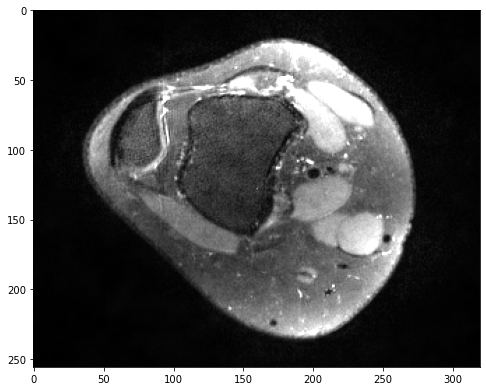

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(np.abs(im_comb_est),cmap='gray', vmax=300)

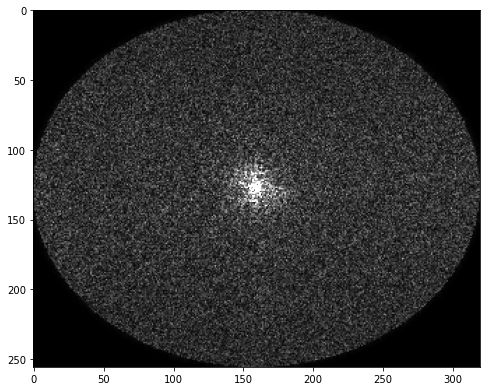

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(np.abs(ksp_err_np[0,0]),cmap='gray', vmax=30)

# Use G to reconstruct SPIRIT

In [14]:
print(kspace.shape, mask.shape)

(320, 8, 256, 320) (256, 320)


In [15]:
masked_kspace = kspace[100:101] * mask[None,None]

In [16]:
# Simple testing : Perform SPIRIT recon

masked_kspace_tensor = torch.from_numpy(masked_kspace).cuda()

print(masked_kspace_tensor.shape)

torch.Size([1, 8, 256, 320])


In [17]:
mask_tensor = masked_kspace_tensor.abs()>0
print(mask_tensor.shape)

torch.Size([1, 8, 256, 320])


In [18]:
kspace_est = masked_kspace_tensor
with torch.no_grad():
    for it in range(10):
        kspace_est = net(kspace_est) * (~mask_tensor) + masked_kspace_tensor * mask_tensor

In [19]:
kspace_est_np = kspace_est.cpu().detach().numpy()
im_comb_est = sp.rss(sp.ifft(kspace_est_np[0], axes=[1,2]), axes=0) # For fully sampled recon img

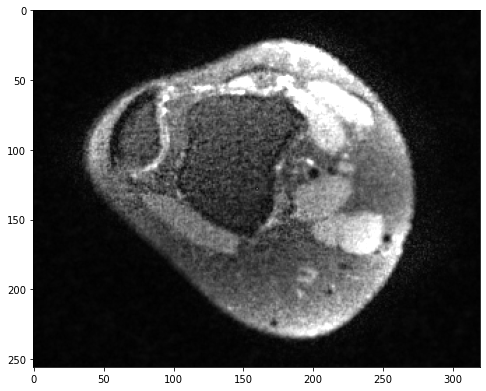

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(np.abs(im_comb_est),cmap='gray',vmax=300)

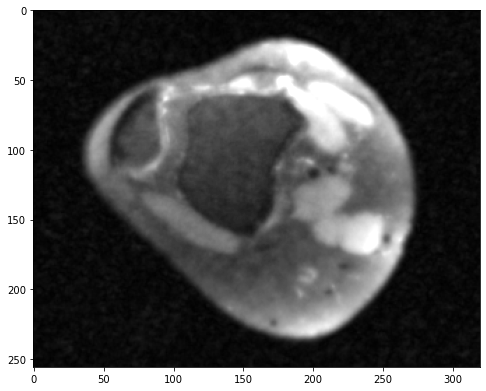

In [21]:
kspace_us_np = masked_kspace_tensor.cpu().detach().numpy()
im_comb_us = sp.rss(sp.ifft(kspace_us_np[0], axes=[1,2]), axes=0) # For fully sampled recon img

plt.figure(figsize=(8,8))
plt.imshow(np.abs(im_comb_us),cmap='gray',vmax=300)

# Use Gradient Descent

In [22]:
criterion = torch.nn.MSELoss()

In [23]:
kspace_spirit = masked_kspace_tensor.clone()
kspace_spirit.requires_grad = True
masked_kspace_tensor.requires_grad = False
optimizer = torch.optim.Adam([kspace_spirit], lr=0.003)

In [24]:
print(kspace_spirit.shape, mask_tensor.shape)

torch.Size([1, 8, 256, 320]) torch.Size([1, 8, 256, 320])


In [ ]:
for epoch in range(10000):
    estY = net(kspace_spirit*(~mask_tensor) + masked_kspace_tensor * mask_tensor) 
    estY_real = torch.view_as_real(estY * (~mask_tensor))
    kspace_spirit_real = torch.view_as_real(kspace_spirit* (~mask_tensor))
    optimizer.zero_grad()
    loss = criterion(kspace_spirit_real, estY_real)
    loss.backward()
    optimizer.step()
    if epoch % 5000 == 0:
        print('Loss={:06f}'.format(loss.item()))
        kspace_spirit_np = kspace_spirit.cpu().detach().numpy()
        im_comb_spirit = sp.rss(sp.ifft(kspace_spirit_np[0], axes=[1,2]), axes=0) # For fully sampled recon img

        plt.figure(figsize=(8,8))
        plt.imshow(np.abs(im_comb_spirit),cmap='gray',vmax=5)
        plt.show()

In [ ]:
kspace_us_np = masked_kspace_tensor.cpu().detach().numpy()
im_comb_us = sp.rss(sp.ifft(kspace_us_np[0], axes=[1,2]), axes=0) # For fully sampled recon img

plt.figure(figsize=(8,8))
plt.imshow(np.abs(im_comb_us),cmap='gray',vmax=5)

# Add VN to the loss

In [25]:
R = 14
fname = 'data/div_knee3d/Test/18.h5'
testset = Subject3D(fname=fname, acc=R)

In [26]:
varnet = VarNet2()
varnet.load_state_dict(torch.load('exp/E2EVN_knee3D.pt'))
varnet = varnet.cuda()

In [27]:
ksp, mask, sens, labels = testset[100]
ksp = ksp.unsqueeze(0).cuda()
mask = mask.unsqueeze(0).cuda()
sens = sens.unsqueeze(0).cuda()

with torch.no_grad():
    out, ksp_out = varnet(ksp, mask, sens)

In [28]:
ksp_init = torch.view_as_complex(ksp_out)
print(ksp_init.shape)

torch.Size([1, 8, 256, 320])


In [29]:
masked_kspace_tensor = torch.view_as_complex(ksp)

In [30]:
mask_tensor = masked_kspace_tensor.abs()>0


In [31]:
kspace_spirit = masked_kspace_tensor.clone()
kspace_spirit.requires_grad = True
masked_kspace_tensor.requires_grad = False
optimizer = torch.optim.Adam([kspace_spirit], lr=0.1)

Loss=7193.684570


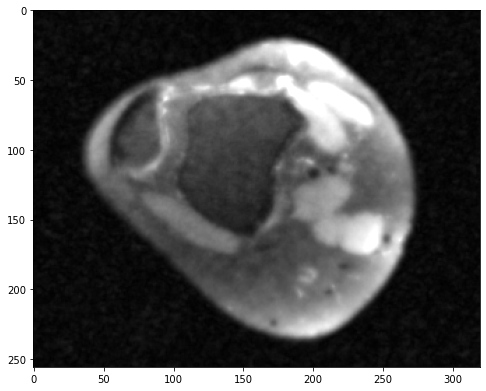

Loss=7111.705566


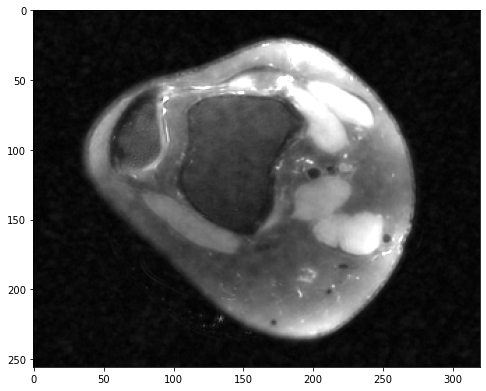

Loss=7094.422852


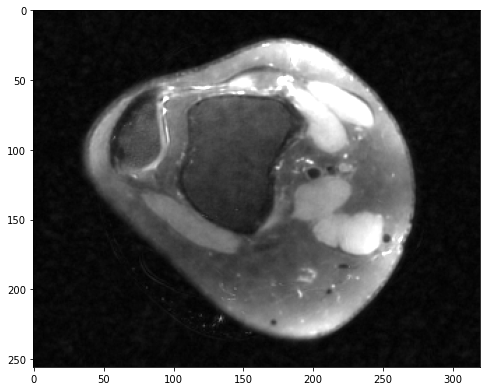

Loss=7094.340332


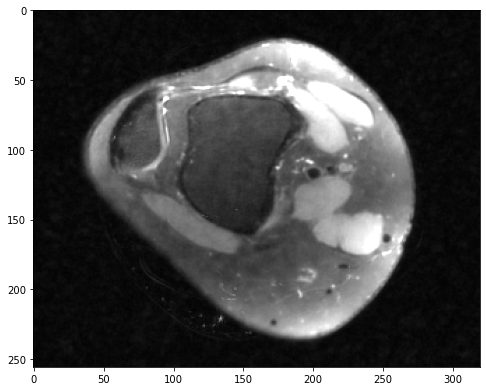

Loss=7102.465332


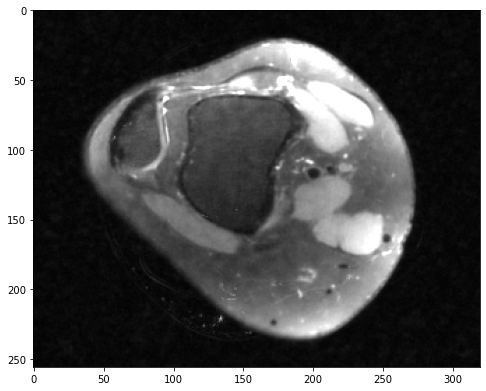

Loss=7115.320312


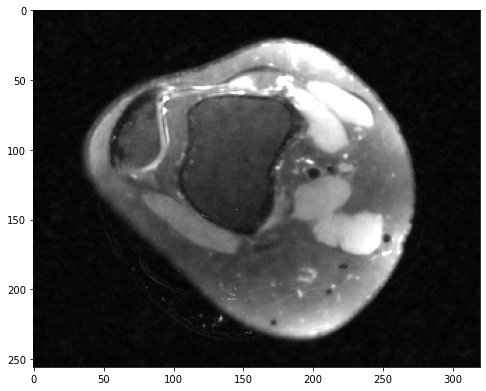

Loss=7131.233398


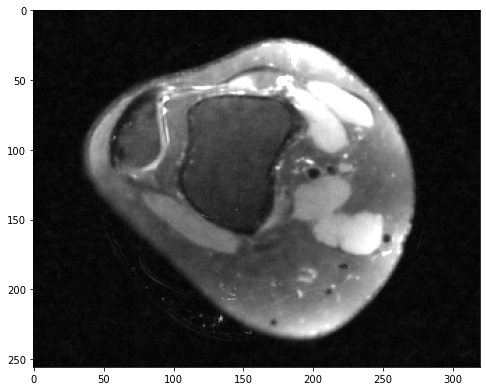

Loss=7149.269531


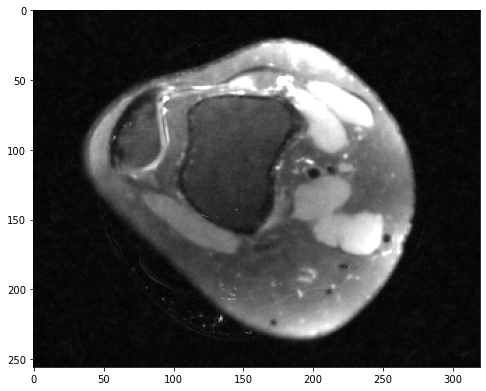

Loss=7168.827637


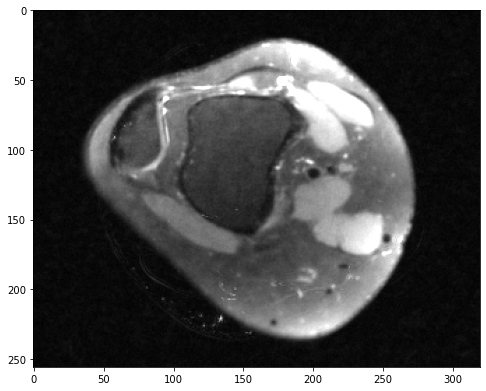

Loss=7189.554688


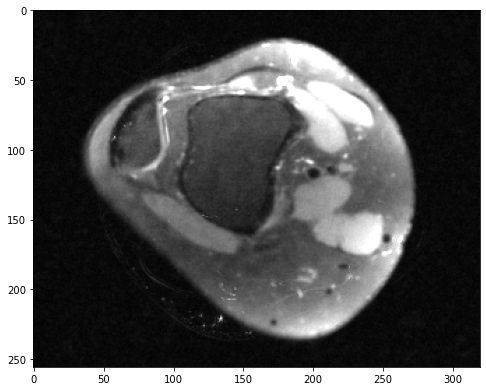

In [32]:
for epoch in range(1000):
    estY = net(kspace_spirit*(~mask_tensor) + masked_kspace_tensor * mask_tensor) 
    estY_real = torch.view_as_real(estY * (~mask_tensor))
    kspace_spirit_real = torch.view_as_real(kspace_spirit* (~mask_tensor))
    optimizer.zero_grad()
    loss1 = criterion(kspace_spirit_real, estY_real) + 10 * criterion(kspace_spirit_real, ksp_out)
    loss1.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Loss={:06f}'.format(loss1.item()))
        kspace_spirit_np = kspace_spirit.cpu().detach().numpy()
        im_comb_spirit = sp.rss(sp.ifft(kspace_spirit_np[0], axes=[1,2]), axes=0) # For fully sampled recon img

        plt.figure(figsize=(8,8))
        plt.imshow(np.abs(im_comb_spirit),cmap='gray',vmax=300)
        plt.show()

In [39]:
kspace_est = ksp_init
with torch.no_grad():
    for it in range(7):
        kspace_est = net(kspace_est) * (~mask_tensor) + masked_kspace_tensor * mask_tensor

In [40]:
kspace_est_np = kspace_spirit.cpu().detach().numpy()
im_comb_est = sp.rss(sp.ifft(kspace_est_np[0], axes=[1,2]), axes=0) # For fully sampled recon img

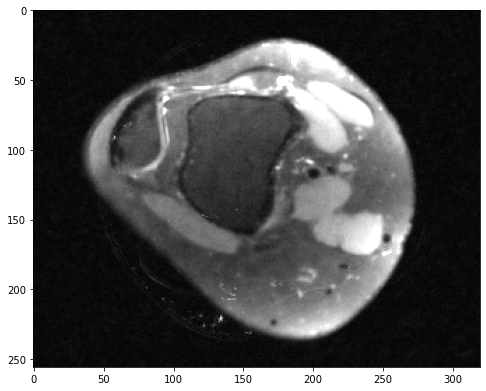

In [41]:
plt.figure(figsize=(8,8))
plt.imshow(np.abs(im_comb_est),cmap='gray', vmax=300)

In [36]:
kspace_est_np = torch.view_as_complex(ksp_out).cpu().detach().numpy()
im_comb_est = sp.rss(sp.ifft(kspace_est_np[0], axes=[1,2]), axes=0) # For fully sampled recon img

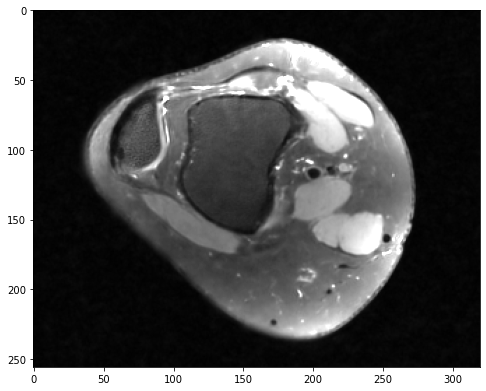

In [37]:
plt.figure(figsize=(8,8))
plt.imshow(np.abs(im_comb_est),cmap='gray', vmax=300)

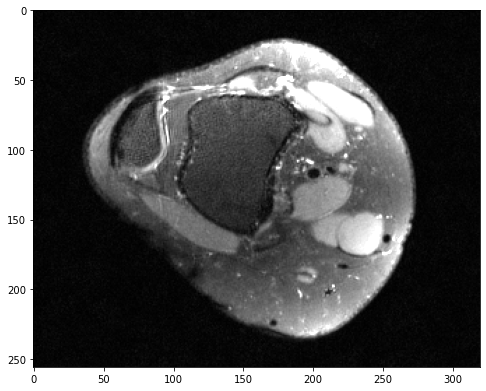

In [38]:
im_label = torch.view_as_complex(labels).cpu().detach().numpy()[0]
plt.figure(figsize=(8,8))
plt.imshow(np.abs(im_label),cmap='gray', vmax=300)